# Data cleaning/mining and feature engineering

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Std Lib
import re

# 3rd Party
import pandas as pd
import pylab as plt
import seaborn as sns

In [2]:
!ls

Baltimore_City_Employee_Salaries_FY2015.csv
Data_mining.ipynb
README.md


## Data Cleaning

In [3]:
data = pd.read_csv('Baltimore_City_Employee_Salaries_FY2015.csv')

In [4]:
# for now just drop the na values that are in the gross pay. we can find an appropriate value for them later
data = data.dropna()

In [5]:
data.head()

,name,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
0,"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev (031),10/24/1979,$55314.00,$53626.04
1,"Aaron,Petra L",ASSISTANT STATE'S ATTORNEY,A29045,States Attorneys Office (045),09/25/2006,$74000.00,$73000.08
2,"Abaineh,Yohannes T",EPIDEMIOLOGIST,A65026,HLTH-Health Department (026),07/23/2009,$64500.00,$64403.84
3,"Abbene,Anthony M",POLICE OFFICER,A99005,Police Department (005),07/24/2013,$46309.00,$59620.16
4,"Abbey,Emmanuel",CONTRACT SERV SPEC II,A40001,M-R Info Technology (001),05/01/2013,$60060.00,$54059.60


In [6]:
data.dtypes

name            object
JobTitle        object
AgencyID        object
Agency          object
HireDate        object
AnnualSalary    object
GrossPay        object
dtype: object

In [7]:
data['Name'] = data.name
del data['name']

In [8]:
data.HireDate = pd.to_datetime(data.HireDate)

In [9]:
# convert all the financial data to floats
x = lambda x: re.findall(r'[^$]*', x)[1]
data['AnnualSalaryFloat'] = data.AnnualSalary.apply(x)
data.AnnualSalaryFloat = pd.to_numeric(data.AnnualSalaryFloat)

data['GrossPayFloat'] = data.GrossPay.apply(x)
data.GrossPayFloat = pd.to_numeric(data.GrossPayFloat)

In [10]:
data.head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay,Name,AnnualSalaryFloat,GrossPayFloat
0,Facilities/Office Services II,A03031,OED-Employment Dev (031),1979-10-24,$55314.00,$53626.04,"Aaron,Patricia G",55314.0,53626.04
1,ASSISTANT STATE'S ATTORNEY,A29045,States Attorneys Office (045),2006-09-25,$74000.00,$73000.08,"Aaron,Petra L",74000.0,73000.08
2,EPIDEMIOLOGIST,A65026,HLTH-Health Department (026),2009-07-23,$64500.00,$64403.84,"Abaineh,Yohannes T",64500.0,64403.84
3,POLICE OFFICER,A99005,Police Department (005),2013-07-24,$46309.00,$59620.16,"Abbene,Anthony M",46309.0,59620.16
4,CONTRACT SERV SPEC II,A40001,M-R Info Technology (001),2013-05-01,$60060.00,$54059.60,"Abbey,Emmanuel",60060.0,54059.60


In [11]:
data.dtypes

JobTitle                     object
AgencyID                     object
Agency                       object
HireDate             datetime64[ns]
AnnualSalary                 object
GrossPay                     object
Name                         object
AnnualSalaryFloat           float64
GrossPayFloat               float64
dtype: object

In [12]:
# this one normalizes 'Agency' column when it = 'Mayors Office' to be 'Mayor's Office'
data.loc[data.loc[:,'Agency'].str.contains('Mayors Office') == True, 'Agency'] = data[data.Agency.str.contains('Mayors Office') == True].Agency.str.replace('Mayors Office', 'Mayor\'s Office')

## Feature Engineering

### Tenure

In [13]:
# calculates the tenure at the time the data was collected
today = pd.datetime(2015, 5, 30)
x = lambda x: today - x
data['Tenure'] = data.HireDate.apply(x)

# creates a feature of tenure in years stored as an int
x = lambda x: int(x / pd.Timedelta(1, 'Y'))
data['TenureYears'] = data.Tenure.apply(x)

In [14]:
# https://www.disabled-world.com/calculators-charts/wedding-Anniversaries.php
# Wooden (5th), Tin (10th), Crystal (15th), China (20th), Silver (25th), Pearl (30th), Ruby (40th), Golden (50th), and Diamond (60th)
def tenure_buckets(tenure_years):
    if tenure_years > 60:
        return 'Diamond(>60)'
    elif tenure_years > 50:
        return 'Gold(>50)'
    elif tenure_years > 40:
        return 'Ruby(>40)'
    elif tenure_years > 30:
        return 'Pearl(>30)'
    elif tenure_years > 25:
        return 'Silver(>25)'
    elif tenure_years > 20:
        return 'China(>20)'
    elif tenure_years > 15:
        return 'Crystal(>15)'
    elif tenure_years > 10:
        return 'Tin(>10)'
    elif tenure_years > 5:
        return 'Wood(>5)'
    else:
        return 'Paper(<5)'

tenure_bucket_order = ['Paper(<5)', 'Wood(>5)', 'Tin(>10)', 'Crystal(>15)', 'China(>20)',
                           'Silver(>25)', 'Pearl(>30)', 'Ruby(>40)', 'Gold(>50)', 'Diamond(>60)']

def tenure_buckets_rank(tenure_years):
    if tenure_years > 60:
        return 1
    elif tenure_years > 50:
        return 2
    elif tenure_years > 40:
        return 3
    elif tenure_years > 30:
        return 4
    elif tenure_years > 25:
        return 5
    elif tenure_years > 20:
        return 6
    elif tenure_years > 15:
        return 7
    elif tenure_years > 10:
        return 8
    elif tenure_years > 5:
        return 9
    else:
        return 10

In [15]:
data['TenureClass'] = data.TenureYears.apply(tenure_buckets)
data['TenureClassRank'] = data.TenureYears.apply(tenure_buckets_rank)

### Agency categories/subcategory

In [16]:
# first 3 of the AgencyID is the AgencyCode
x = lambda x: x[:-3]
data['AgencyCode'] = data.AgencyID.apply(x)

# first 3 of the AgencyID is the AgencySubCode
x = lambda x: x[-3:]
data['AgencySubCode'] = data.AgencyID.apply(x)

In [17]:
# this crazy regex is to strip the trailing code data at the end of Agency
# https://regex101.com/r/9F56Wh/1
x = lambda x: re.sub(r' \([\w-]+\) *\(*[\w]*\)*|-Hea[lt]{2}h.*| \(.*| \d+', '', x)
data['AgencyCat'] = data.Agency.apply(x)

In [18]:
data.head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay,Name,AnnualSalaryFloat,GrossPayFloat,Tenure,TenureYears,TenureClass,TenureClassRank,AgencyCode,AgencySubCode,AgencyCat
0,Facilities/Office Services II,A03031,OED-Employment Dev (031),1979-10-24,$55314.00,$53626.04,"Aaron,Patricia G",55314.0,53626.04,13002 days,35,Pearl(>30),4,A03,031,OED-Employment Dev
1,ASSISTANT STATE'S ATTORNEY,A29045,States Attorneys Office (045),2006-09-25,$74000.00,$73000.08,"Aaron,Petra L",74000.0,73000.08,3169 days,8,Wood(>5),9,A29,045,States Attorneys Office
2,EPIDEMIOLOGIST,A65026,HLTH-Health Department (026),2009-07-23,$64500.00,$64403.84,"Abaineh,Yohannes T",64500.0,64403.84,2137 days,5,Paper(<5),10,A65,026,HLTH
3,POLICE OFFICER,A99005,Police Department (005),2013-07-24,$46309.00,$59620.16,"Abbene,Anthony M",46309.0,59620.16,675 days,1,Paper(<5),10,A99,005,Police Department
4,CONTRACT SERV SPEC II,A40001,M-R Info Technology (001),2013-05-01,$60060.00,$54059.60,"Abbey,Emmanuel",60060.0,54059.60,759 days,2,Paper(<5),10,A40,001,M-R Info Technology


In [19]:
data.pivot_table(index=['AgencyCode', 'AgencyCat'], aggfunc=pd.Series.nunique, values=['Agency','Name'])

,,Agency,Name
AgencyCode,AgencyCat,,
A01,Mayor's Office,3,93
A02,City Council,3,93
A03,OED-Employment Dev,17,159
A04,R&P-Recreation,9,139
A06,Housing & Community Dev,30,383
A08,M-R Human Services,12,149
A09,Liquor License Board,2,24
A12,FIN-Acct & Payroll,3,51
A14,FIN-Collections,8,131


### First/Last Name, MI and Suffix

In [20]:
x = lambda x: x.split(',')[1].split(' ')[0]
data['FirstName'] = data.Name.apply(x)

x = lambda x: x.split(',')[1].split(' ')[1] if len(x.split(',')[1].split(' ')) > 1 else ''
data['MiddleInitial'] = data.Name.apply(x)

x = lambda x: x.split(',')[0]
data['LastName'] = data.Name.apply(x)

In [21]:
# LastName Sr's & Jr's account for 700+ employees, lets clean that up
    #this is a naive selector.. (counter example Sriam)
    # data[data['Name'].str.contains('Jr') | data['LastName'].str.contains('Sr')]

# https://regex101.com/r/OIewK9/1
# first we are pulling out the suffix into a new field
x = lambda x: re.findall(r'[JS]r[\.]?$', x)[0] if len(re.findall(r'[JS]r[\.]?$', x)) > 0 else ''
data['SuffixName'] = data.LastName.apply(x)

# then we are replacing the instance inside of the Last name field
x = lambda x: re.sub(r'[JS]r[\.]?$', '', x)
data.LastName = data.LastName.apply(x)

### Wages and Approx. hours

In [22]:
def salary_buckets(salary):
    if salary > 150 * 10**3:
        return '>150K'
    elif salary > 125 * 10**3:
        return '>125K'
    elif salary > 100 * 10**3:
        return '>100K'
    elif salary > 75 * 10**3:
        return '>75K'
    elif salary > 50 * 10**3:
        return '>50K'
    elif salary > 25 * 10**3:
        return '>25K'
    else:
        return '<25K'

salary_bucket_order = ['<25K', '>25K', '>50K', '>75K', '>100K', '>125K', '>150K']    

def salary_bucket_ranks(salary):
    if salary > 150 * 10**3:
        return 1
    elif salary > 125 * 10**3:
        return 2
    elif salary > 100 * 10**3:
        return 3
    elif salary > 75 * 10**3:
        return 4
    elif salary > 50 * 10**3:
        return 5
    elif salary > 25 * 10**3:
        return 7
    else:
        return 8

In [23]:
data['AnnualSalaryBucket'] = data.AnnualSalaryFloat.apply(salary_buckets)
data['AnnualSalaryBucketRank'] = data.AnnualSalaryFloat.apply(salary_bucket_ranks)

data['GrossPayBucket'] = data.GrossPayFloat.apply(salary_buckets)
data['GrossPayBucketRank'] = data.GrossPayFloat.apply(salary_bucket_ranks)

In [24]:
# approximate hourly rate
x = lambda x: x/2080
data['ApproxHourlyRate'] = data.AnnualSalaryFloat.apply(x)

In [25]:
# try to approximate hours worked
# if GrossPay > AnnualSalary:
#     2080 + (GrossPay - AnnualSalary) / (ApproxHourlyRate * 1.5)
# else:
#     (GrossPay / ApproxHourlyRate)

def approx_hours_worked(row):
    if row['GrossPayFloat'] > row['AnnualSalaryFloat']:
        return 2080 + (row['GrossPayFloat'] - row['AnnualSalaryFloat']) / (row['ApproxHourlyRate'] * 1.5)
    else:
        return row['GrossPayFloat'] / row['ApproxHourlyRate']

In [26]:
data['ApproxHoursWorked'] = data.apply(approx_hours_worked, axis=1)

In [27]:
data['ApproxAvgWeeklyHours'] = data.ApproxHoursWorked / 52

In [28]:
data.head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay,Name,AnnualSalaryFloat,GrossPayFloat,Tenure,...,MiddleInitial,LastName,SuffixName,AnnualSalaryBucket,AnnualSalaryBucketRank,GrossPayBucket,GrossPayBucketRank,ApproxHourlyRate,ApproxHoursWorked,ApproxAvgWeeklyHours
0,Facilities/Office Services II,A03031,OED-Employment Dev (031),1979-10-24,$55314.00,$53626.04,"Aaron,Patricia G",55314.0,53626.04,13002 days,...,G,Aaron,,>50K,5,>50K,5,26.593269,2016.526796,38.779361
1,ASSISTANT STATE'S ATTORNEY,A29045,States Attorneys Office (045),2006-09-25,$74000.00,$73000.08,"Aaron,Petra L",74000.0,73000.08,3169 days,...,L,Aaron,,>50K,5,>50K,5,35.576923,2051.894141,39.459503
2,EPIDEMIOLOGIST,A65026,HLTH-Health Department (026),2009-07-23,$64500.00,$64403.84,"Abaineh,Yohannes T",64500.0,64403.84,2137 days,...,T,Abaineh,,>50K,5,>50K,5,31.009615,2076.899026,39.940366
3,POLICE OFFICER,A99005,Police Department (005),2013-07-24,$46309.00,$59620.16,"Abbene,Anthony M",46309.0,59620.16,675 days,...,M,Abbene,,>25K,7,>50K,5,22.263942,2478.586492,47.665125
4,CONTRACT SERV SPEC II,A40001,M-R Info Technology (001),2013-05-01,$60060.00,$54059.60,"Abbey,Emmanuel",60060.0,54059.60,759 days,...,,Abbey,,>50K,5,>50K,5,28.875000,1872.193939,36.003730


### Employee Type (FTE, PTE, Hourly, seasonal)

In [29]:
# gotta initialize the column so values dont start as NaN
data['EmployeeType'] = ''

In [30]:
# sets employee type to 'Hourly' if JobTitle contains hourly
data.loc[data.loc[:,'JobTitle'].str.contains('Hourly') == True, 'EmployeeType'] = 'Hourly'

In [31]:
# sets employee type to 'Hourly' if Agency contains hourly
data.loc[data.loc[:,'Agency'].str.contains('part-time') == True, 'EmployeeType'] = 'Part-Time'

In [32]:
# sets employee type to 'Seasonal' if JobTitle contains seasonal
data.loc[data.loc[:,'JobTitle'].str.contains('SEASONAL') == True, 'EmployeeType'] = 'Seasonal'

In [33]:
# if employee type is blank assign 'Full-Time'
x = lambda x: 'Full-Time' if x == '' else x
data.EmployeeType = data.EmployeeType.apply(x)

In [34]:
data.pivot_table(index='EmployeeType', aggfunc='mean')

,AnnualSalaryBucketRank,AnnualSalaryFloat,ApproxAvgWeeklyHours,ApproxHourlyRate,ApproxHoursWorked,GrossPayBucketRank,GrossPayFloat,TenureClassRank,TenureYears
EmployeeType,,,,,,,,,
Full-Time,5.786988,54622.429743,40.133393,26.260784,2086.936460,5.541886,58930.212833,7.948559,13.112279
Hourly,7.000000,30614.511384,44.149693,14.718515,2295.784018,6.971979,35571.466637,8.262697,11.532399
Part-Time,7.895833,21606.736111,12.878285,10.387854,669.670833,7.995370,7164.097338,9.458333,4.759259
Seasonal,7.994350,22458.192090,26.558684,10.797208,1381.051558,7.807910,15196.108814,9.853107,1.864407


### Job Title level

In [35]:
# creating a feature for the Level of the Job Title
# r'I+$' looks for I one or more times at the end of the string
x = lambda x: len(re.findall(r'I+$', x)[0]) if len(re.findall(r'I+$', x)) > 0 else 'NaN'
data['JobTitleLevel'] = data.JobTitle.apply(x)

In [36]:
data.pivot_table(index='JobTitleLevel', aggfunc='count')

,Agency,AgencyCat,AgencyCode,AgencyID,AgencySubCode,AnnualSalary,AnnualSalaryBucket,AnnualSalaryBucketRank,AnnualSalaryFloat,ApproxAvgWeeklyHours,...,HireDate,JobTitle,LastName,MiddleInitial,Name,SuffixName,Tenure,TenureClass,TenureClassRank,TenureYears
JobTitleLevel,,,,,,,,,,,,,,,,,,,,,
1,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526,...,1526,1526,1526,1526,1526,1526,1526,1526,1526,1526
2,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762,...,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762
3,658,658,658,658,658,658,658,658,658,658,...,658,658,658,658,658,658,658,658,658,658
NaN,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792,...,9792,9792,9792,9792,9792,9792,9792,9792,9792,9792


## Interesting data points

In [37]:
data[data.AnnualSalaryBucketRank - data.GrossPayBucketRank > 2].head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay,Name,AnnualSalaryFloat,GrossPayFloat,Tenure,...,SuffixName,AnnualSalaryBucket,AnnualSalaryBucketRank,GrossPayBucket,GrossPayBucketRank,ApproxHourlyRate,ApproxHoursWorked,ApproxAvgWeeklyHours,EmployeeType,JobTitleLevel
119,POLICE OFFICER (EID),A99165,Police Department (165),2006-08-30,$70967.00,$132393.37,"Albino,Edwin",70967.0,132393.37,3195 days,...,,>50K,5,>125K,2,34.118750,3280.246590,63.081665,Full-Time,NaN
255,POLICE OFFICER,A99197,Police Department (197),2007-10-18,$65446.00,$138390.07,"Ambrose,Wayne S",65446.0,138390.07,2781 days,...,,>50K,5,>125K,2,31.464423,3625.535409,69.721835,Full-Time,NaN
289,POLICE OFFICER (EID),A99389,Police Department (389),1997-09-30,$75641.00,$151133.38,"Anderson,Charles",75641.0,151133.38,6451 days,...,,>75K,4,>150K,1,36.365865,3463.942134,66.614272,Full-Time,NaN
309,ELECTRICAL MECHANIC II,A49390,TRANS-Highways (390),2006-07-31,$38339.00,$87003.70,"Anderson,Kenneth A",38339.0,87003.70,3225 days,...,,>25K,7,>75K,4,18.432212,3840.132433,73.848701,Full-Time,2
440,PARAMEDIC EMT-P,A64463,Fire Department (463),2003-01-15,$70647.00,$179508.87,"Atkinson Jr,Ronnie G",70647.0,179508.87,4518 days,...,Jr,>50K,5,>150K,1,33.964904,4216.752111,81.091387,Full-Time,NaN


In [38]:
data[data.TenureYears > 50]

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay,Name,AnnualSalaryFloat,GrossPayFloat,Tenure,...,SuffixName,AnnualSalaryBucket,AnnualSalaryBucketRank,GrossPayBucket,GrossPayBucketRank,ApproxHourlyRate,ApproxHoursWorked,ApproxAvgWeeklyHours,EmployeeType,JobTitleLevel
12966,CIVIL ENGINEERING DRAFTING SUP,A50101,DPW-Water & Waste Water (101),1952-06-23,$57008.00,$57241.70,"Walter,William",57008.0,57241.70,22986 days,...,,>50K,5,>50K,5,27.407692,2085.684536,40.109318,Full-Time,NaN
13364,OFFICE ASST III,A75058,Enoch Pratt Free Library (058),1962-04-03,$38959.00,$39060.45,"Whitt,Sadie E",38959.0,39060.45,19415 days,...,,>25K,7,>25K,7,18.730288,2083.610907,40.069441,Full-Time,3
13860,CONTRACT ADMINISTRATOR II,A41102,DPW-Administration (102),1961-06-18,$59482.00,$60426.57,"Wright,Howard F",59482.0,60426.57,19704 days,...,,>50K,5,>50K,5,28.597115,2102.020170,40.423465,Full-Time,2
13990,SURVEY TECHNICIAN IV,A49106,TRANS-Highways (106),1963-12-10,$59482.00,$59739.19,"Zemon,Wayne",59482.0,59739.19,18799 days,...,,>50K,5,>50K,5,28.597115,2085.995710,40.115302,Full-Time,NaN


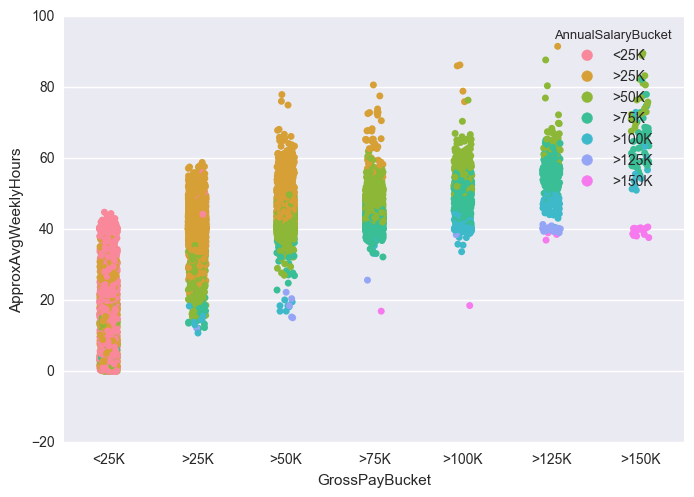

In [43]:
sns.stripplot(x='GrossPayBucket', y='ApproxAvgWeeklyHours', data= data, jitter=True, order=salary_bucket_order, hue='AnnualSalaryBucket', hue_order= salary_bucket_order)

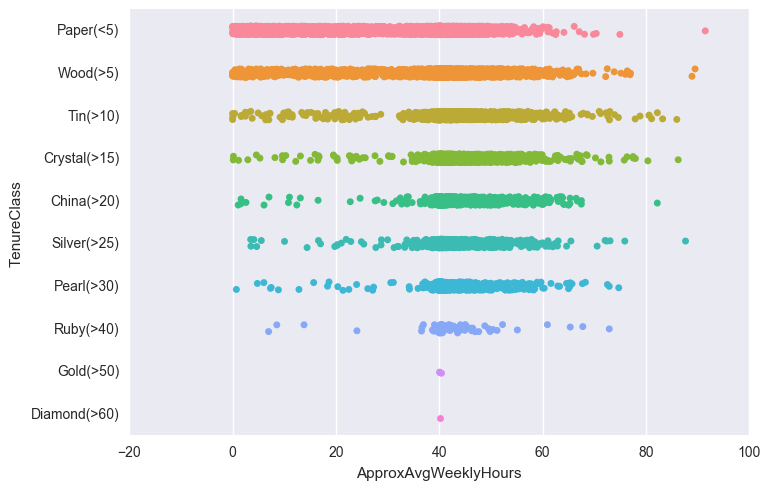

In [40]:
sns.stripplot(y='TenureClass', x='ApproxAvgWeeklyHours', data=data, jitter=True, order=tenure_bucket_order, orient='h')

In [41]:
data[data.ApproxAvgWeeklyHours < 10]

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay,Name,AnnualSalaryFloat,GrossPayFloat,Tenure,...,SuffixName,AnnualSalaryBucket,AnnualSalaryBucketRank,GrossPayBucket,GrossPayBucketRank,ApproxHourlyRate,ApproxHoursWorked,ApproxAvgWeeklyHours,EmployeeType,JobTitleLevel
9,LIFEGUARD I,P04002,R&P-Recreation (part-time) (,2014-06-18,$18408.00,$1051.25,"Abdul Aziz,Hajr E",18408.0,1051.25,346 days,...,,<25K,8,<25K,8,8.850000,118.785311,2.284333,Part-Time,1
10,LIFEGUARD I,P04002,R&P-Recreation (part-time) (,2014-06-16,$18408.00,$1051.25,"Abdul Aziz,Jennah A",18408.0,1051.25,348 days,...,,<25K,8,<25K,8,8.850000,118.785311,2.284333,Part-Time,1
11,LIFEGUARD I,P04002,R&P-Recreation (part-time) (,2014-06-09,$18408.00,$1051.25,"Abdul Aziz,Yaqub M",18408.0,1051.25,355 days,...,,<25K,8,<25K,8,8.850000,118.785311,2.284333,Part-Time,1
22,RECREATION ARTS INSTRUCTOR,P04001,R&P-Recreation (part-time) (,2007-06-25,$22880.00,$2233.00,"Abid,Paula",22880.0,2233.00,2896 days,...,,<25K,8,<25K,8,11.000000,203.000000,3.903846,Part-Time,NaN
31,RECREATION ARTS INSTRUCTOR,P04001,R&P-Recreation (part-time) (,2014-06-19,$20800.00,$1690.00,"Abrams,Terry",20800.0,1690.00,345 days,...,,<25K,8,<25K,8,10.000000,169.000000,3.250000,Part-Time,NaN
42,STOREKEEPER II,A49320,TRANS-Highways (320),2015-03-30,$30834.00,$6907.73,"Adabah,Fred",30834.0,6907.73,61 days,...,,>25K,7,<25K,8,14.824038,465.981657,8.961186,Full-Time,2
48,COMMUNITY AIDE,A68011,R&P-Parks (011),2015-04-20,$21320.00,$3127.89,"Adams,Charles",21320.0,3127.89,40 days,...,,<25K,8,<25K,8,10.250000,305.160000,5.868462,Full-Time,NaN
145,COLLECTIONS REPRESENTATIVE I,A14003,FIN-Collections (003),2015-05-14,$30834.00,$2371.84,"Alford,Tatia M",30834.0,2371.84,16 days,...,,>25K,7,<25K,8,14.824038,159.999585,3.076915,Full-Time,1
161,CONSTRUCTION BLDG INSPECTOR II,A06034,Housing & Community Dev (034),2015-05-11,$44414.00,$4953.73,"Allen,Cedric M",44414.0,4953.73,19 days,...,,>25K,7,<25K,8,21.352885,231.993480,4.461413,Full-Time,2
170,SECURITY GUARD CONV. CENTER,A91018,M-R Convention Center (018),2003-01-09,$23920.00,$0.00,"Allen,Fred H",23920.0,0.00,4524 days,...,,<25K,8,<25K,8,11.500000,0.000000,0.000000,Full-Time,NaN
